## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project I performed an A/B test to understand whether the implementation of the new web page for an e-commerce website generates a significant increase in the conversion rate of users compared to the old page.

The dataset contains users who were divided in two groups, group and treatment. The users in the control group were given the old page of the website; the users in the treatment group were given the new page.

<a id='probability'></a>
#### Part I - Probability

Let's import the libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
random.seed(42)

Read the dataset and show the first rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows in the dataset.

In [3]:
df.shape[0]

294478

Number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

Proportion of users converted.

In [5]:
print(np.round(df.loc[df['converted']==1].shape[0]/df.shape[0],2)*100,'%')

12.0 %


Check for missing values.

In [6]:
df.isnull().sum().any()

False

Check if there are rows in which the group (control/treatment) is not aligned with the landing page (old/new). Users in the control group were given the old page, users in the treatment group were given the new page.

In [7]:
df.groupby('group')['landing_page'].value_counts()

group      landing_page
control    old_page        145274
           new_page          1928
treatment  new_page        145311
           old_page          1965
Name: landing_page, dtype: int64

Drop the rows where the two columns are not aligned.

In [8]:
df2 = df.drop(df.loc[(df['group'] == 'control')&(df['landing_page']=='new_page')|(df['group'] == 'treatment')&(df['landing_page']=='old_page')].index)

Look for repeated user in the new dataframe.

In [9]:
df2.loc[df2.duplicated(subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove the repeated user.

In [10]:
df2= df2.drop_duplicates(subset=['user_id'])

In [11]:
sum(df2.duplicated(subset=['user_id']))

0

Probability of conversion of an user, regardless of the page.

In [12]:
df2.loc[df2['converted']==1].shape[0]/df2.shape[0]

0.11959708724499628

Probability of conversion of users that belong to the control group (thus they were given the old page).

In [13]:
df2.loc[(df2['converted']==1)&(df2['group']=='control')].shape[0]/df2.loc[df2['group']=='control'].shape[0]

0.1203863045004612

Probability of conversion of users that belong to the treatment group (thus they were given the new page).

In [14]:
df2.loc[(df2['converted']==1)&(df2['group']=='treatment')].shape[0]/df2.loc[df2['group']=='treatment'].shape[0]

0.11880806551510564

Probability that an user was given the new page.

In [15]:
df2.loc[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

So far we don't have enough evidence to say that the new page leads to more conversions, because the probability of conversion of the treatment group is almost identical to the probability of conversion of the control group. The size of the two groups is also the same.

<a id='ab_test'></a>
### Part II - A/B Test

We want to test whether the new page is better than the old one. Let's define
<ul>
    <li><i>p<sub>new</sub></i> as the conversion rate for the new page</li>
    <li><i>p<sub>old</sub></i> as the conversion rate for the old page</li>
</ul>

We assume that the old page is better unless the new page proves to be better at a Type I Error rate α of 5%.

Null Hypothesis H<sub>0</sub> : p<sub>new</sub> ≤ p<sub>old</sub>

Alternative Hypothesis H<sub>1</sub> : p<sub>new</sub> > p<sub>old</sub>

##### Method 1: Sampling DIstribution
Let's assume, under the null hypothesis, that the two parameters are equal and they equal to our statistics, the conversion rate in our sample data regardless of the page.

Conversion rate for the new page under the null hypothesis.

In [16]:
p_new = df2.loc[df2['converted']==1].shape[0]/df2.shape[0]
p_new

0.11959708724499628

Conversion rate for the old page under the null hypothesis.

In [17]:
p_old = df2.loc[df2['converted']==1].shape[0]/df2.shape[0] #Equal to the above
p_old

0.11959708724499628

Number of observations for the new page.

In [18]:
n_new = df2.loc[df2['landing_page']=='new_page'].shape[0]
n_new

145310

Number of observations for the old page.

In [19]:
n_old = df2.loc[df2['landing_page']=='old_page'].shape[0]
n_old

145274

We now simulate the sampling distribution for the difference in proportions p<sub>new</sub> - p<sub>old</sub>

In [20]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, (1- p_new)]).mean()
    old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, (1- p_old)]).mean()
    diff = new_page_converted - old_page_converted
    p_diffs.append(diff)
p_diffs = np.array(p_diffs)

Plot a histogram of the calculated differences.

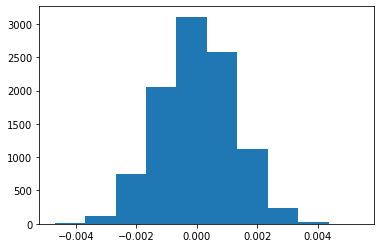

In [21]:
plt.hist(p_diffs);

As expected, the values follow a normal distribution The Central Limit Theorem states that if the sample is large enough, the difference in sample proportions will be normally distributed.

Let's calculate the actual difference between the conversion rate of the two groups (treatment and control) in our dataset.

In [22]:
obs_diff = df2.loc[df2['group']=='treatment']['converted'].mean()-df2.loc[df2['group']=='control']['converted'].mean()
obs_diff

-0.0015782389853555567

Proportion of values under the null hypothesis that are greater than the actual difference just calculated.

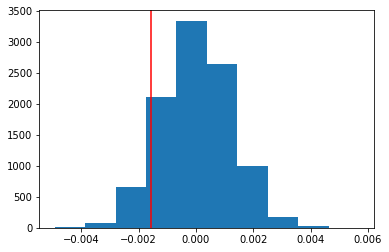

In [23]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(obs_diff, c='red');

In [24]:
(null_vals > obs_diff).mean()

0.9049

The computed value is called p-value, which is the probability of obtaining the observed statistic or a more extreme value (in favor of the alternative hypothesis), under the assumption that the null hypothesis is correct. The main interpretation of the p-value is whether there is enough evidence to reject the null hypothesis. If the p-value is reasonably low (less than the level of significance α, which is the probability of making Type I Errors that we are willing to accept), we can state that there is enough evidence to reject the null hypothesis. Usually α=5%.

In this case, the p-value is greater than 0.9, therefore we don't have enough evidence to reject our null hypothesis and we can conclude that there isn't a statistically significant difference in the conversion rate between the new page and the old page.

##### Method 2: Z-test
We can obtain a similar result using a two-proportion Z-test, a statistical test used to compare two population proportions to see if they are equal, when the sample size is large.

In [25]:
convert_old = df2.loc[(df2['converted']==1)&(df['landing_page']=='old_page')].shape[0]
convert_new = df2.loc[(df2['converted']==1)&(df['landing_page']=='new_page')].shape[0]

Compute the z-score and p-value.

In [26]:
#Alternative is larger because we are testing H1: p_new > p_old
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old], nobs=[n_new, n_old], alternative='larger')
print("Z-score: ", z_score)
print("P-value: ", p_value)

Z-score:  -1.3109241984234394
P-value:  0.9050583127590245


The p-value is greater than 0.9, very similar to the one obtained in the above section. Again, we cannot reject the null hypothesis because there isn't a statistically significant difference between the two conversion rates.

<a id='regression'></a>
### Part III - A regression approach

The result obtained in the previous A/B test can also be achieved using a regression approach. Since the response variable is categorical we should perform a logistic regression.

Create a dummy variable for the group and add an intercept column.

In [27]:
df2['intercept'] = 1
df2=df2.join(pd.get_dummies(df2['group']))
df2.drop(['control'], axis=1, inplace=True)
df2 = df2.rename(columns={'treatment': 'ab_page'})
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Instantiate and fit the model to predict whether or not an individual converts or not using only the information about the group he belongs to.

In [28]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 24 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        21:49:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with ab_page is different compared to the one found in Part II because the hypotheses are different: in Part II we were testing whether the conversion rate of the new layout was <i>greater</i> than the conversion rate of the old one (one-tailed test); now we are testing whether the conversion rate of the new layout is <i>different</i> than the conversion rate of the old one (two-tailed test).

Null Hypothesis H<sub>0</sub> : p<sub>new</sub> = p<sub>old</sub>

Alternative Hypothesis H<sub>1</sub> : p<sub>new</sub> ≠ p<sub>old</sub>

In this case too the p-value is greater than the level of significance α (usually 5%), therefore we cannot reject the null hypothesis.

By including other predictors into the regression model we might be able to to increase the variability of the response variable that is explained by the model, therefore increasing the accuracy of the predictions. However, the disadvantage of adding more predictors into the regression model is that we increase the possibility to include variables that are correlated to one another (multicollinearity). Multicollinearity affects coefficients and p-values, leading to misinterpretations of the effects of these variables on the response variable.

Add to the model an effect based on which country a user lives.

In [29]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new = df_new.join(pd.get_dummies(df_new['country']))
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1


In [30]:
logit_mod_2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'CA', 'UK']])
results_2 = logit_mod_2.fit()
results_2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 24 Jan 2021   Pseudo R-squ.:               2.323e-05
Time:                        21:49:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

The two dummy variables for the countries have p-values that are greater than the level of significance α=5%, therefore we cannot reject the null hypothesis that the two variables have no impact on conversion.

Let's also add the interaction effect between page and country to see if there is a significant effect on conversion.

In [31]:
df_new['CAxpage']=df_new['CA']*df_new['ab_page']
df_new['UKxpage']=df_new['UK']*df_new['ab_page']
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CAxpage,UKxpage
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0


In [32]:
logit_mod_3 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'CA', 'UK', 'CAxpage', 'UKxpage']])
results_3 = logit_mod_3.fit()
results_3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 24 Jan 2021   Pseudo R-squ.:               3.482e-05
Time:                        21:49:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CAxpage       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UKxpage        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Even after adding the interaction effect between the page and the country we can clearly see that these variables still do not have a statistically significant effect on conversion. On the contrary, the interaction effect decreased the significance of the original country variables.

### Conclusions
To conclude, based on the data collected we cannot reject the null hypothesis that the new and the old page have the same conversion rate.Therefore, neither statistically or practically would be convenient investing money in the development of the new web page.

### Limitations
The main limitations of this analysis are related to the fact that there might be some variables not included in the model that could have an impact on conversion rates. For example, the fact that an user was an existing user or a new user should taken into consideration: existing users may give an unfair advantage to the old version simply because they are unhappy with the change (change aversion), or, on the contrary, may give an unfair advantage to the new version because they are drawn to the change (novelty effect).